In [1]:
!wget "https://lp-prod-resources.s3.amazonaws.com/276/45126/2021-02-18-15-03-59/MelanomaDetectionLabeled.zip"

--2024-01-02 16:10:26--  https://lp-prod-resources.s3.amazonaws.com/276/45126/2021-02-18-15-03-59/MelanomaDetectionLabeled.zip
Resolving lp-prod-resources.s3.amazonaws.com (lp-prod-resources.s3.amazonaws.com)... 52.92.193.217, 52.218.218.91, 52.92.147.41, ...
Connecting to lp-prod-resources.s3.amazonaws.com (lp-prod-resources.s3.amazonaws.com)|52.92.193.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 677596 (662K) [application/octet-stream]
Saving to: ‘MelanomaDetectionLabeled.zip.1’

MelanomaDetectionLa 100%[===================>] 661.71K  3.10MB/s    in 0.2s    

2024-01-02 16:10:27 (3.10 MB/s) - ‘MelanomaDetectionLabeled.zip.1’ saved [677596/677596]



In [2]:
import zipfile
with zipfile.ZipFile("MelanomaDetectionLabeled.zip", 'r') as zip_ref:
    zip_ref.extractall("MelanomaDetectionLabeled")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [4]:
torch.manual_seed(1)

# Load data and create dataset

In [5]:
import glob

base_data_path = "./MelanomaDetectionLabeled/MelanomaDetectionLabeled/"

In [6]:
x_train = []
y_train = []

for img in glob.glob(f"{base_data_path}/labeled/*.jpg"):
    _x = read_image(img)
    _y = int(img.split(".")[1][-1])
    x_train.append(_x)
    y_train.append(_y)

In [7]:
x_test = []
y_test = []

for img in glob.glob(f"{base_data_path}/test/*.jpg"):
    _x = read_image(img)
    _y = int(img.split(".")[1][-1])
    x_test.append(_x)
    y_test.append(_y)

In [8]:
from torchvision.transforms import v2

class Melanoma(Dataset):
    def __init__(self, x, y, transform=False):
        super(Melanoma, self).__init__()
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        transform = v2.Compose([v2.ToTensor()])
        x = transform(self.x[idx]).to(torch.float32)
        if self.transform:
            augment = v2.Compose([
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomVerticalFlip(p=0.5)
            ])
            x = augment(x)

        return x, self.y[idx]

In [9]:
train_data = Melanoma(x_train, y_train, transform=True)
trainloader = DataLoader(train_data, shuffle=True, batch_size=64)

test_data = Melanoma(x_test, y_test)
testloader = DataLoader(test_data, batch_size=len(train_data))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


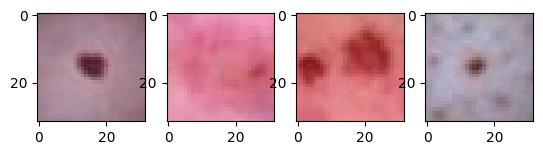

In [10]:
import matplotlib.pyplot as plt

samples = next(iter(trainloader))[0][:4, :, :, :].to(int)

fig, ax = plt.subplots(1, 4)

for i, img in enumerate(samples):
    ax[i].imshow(torch.moveaxis(img, 0, -1))

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pooling):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(pooling)
        self.modules = [self.conv, self.relu, self.pool]

    def forward(self, x):
        for l in self.modules:
            x = l(x)
        return x

In [12]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.modules = [self.linear, self.relu, self.dropout]

    def forward(self, x):
        for l in self.modules:
            x = l(x)
        return x

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = ConvBlock(3, 32, 3, 2) # 32x30x30 --pool--> 32x15x15
        self.conv2 = ConvBlock(32, 64, 3, 2) # 64x13x13 --pool--> 64x7x7
        self.conv3 = ConvBlock(64, 16, 2, 2) # 16x6x6 --pool--> 16x2x2
        self.flatten = nn.Flatten()
        self.linear1 = LinearBlock((16*2*2), 100, 0.3)
        self.linear2 = LinearBlock(100, 64, 0.3)
        self.linear3 = LinearBlock(64, 16, 0.2)
        self.linear4 = nn.Linear(16, 1)
        self.sigmoid = torch.sigmoid
        self.modules = [
            self.conv1, self.conv2, self.conv3, self.flatten, self.linear1, self.linear2, self.linear3, self.linear4, self.sigmoid
        ]

    def forward(self, x):
        for l in self.modules:
            x = l(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
loss_fn = nn.BCELoss()

In [16]:
import numpy as np

num_epochs = 200
train_accs = []
test_accs = []
train_loss = []

for epoch in range(num_epochs):
    losses = []
    correct = 0
    samples = 0
    for x, y in trainloader:
        x = x.to(device)
        y = y.view(len(y), 1).to(torch.float32).to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        samples += len(y)
        correct += (pred.round() == y).sum()

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            y = y.view(len(y), 1).to(torch.float32).to(device)
            pred = model(x)
            test_acc = ((pred.round() == y).sum() / len(y)).cpu().item()

    epoch_loss = np.mean(losses)
    train_acc = (correct/samples).item()
    train_loss.append(np.mean(losses))
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if (epoch+1) % 10 == 0:
        print(f"{epoch+1} - Loss: {epoch_loss} - Acc: {train_acc} - Test Acc: {test_acc}")

10 - Loss: 0.7021540254354477 - Acc: 0.5049999952316284 - Test Acc: 0.5600000023841858
20 - Loss: 0.6779287308454514 - Acc: 0.5699999928474426 - Test Acc: 0.6100000143051147
30 - Loss: 0.577841654419899 - Acc: 0.6850000023841858 - Test Acc: 0.7199999690055847
40 - Loss: 0.624444842338562 - Acc: 0.699999988079071 - Test Acc: 0.699999988079071
50 - Loss: 0.5688071548938751 - Acc: 0.7149999737739563 - Test Acc: 0.625
60 - Loss: 0.5483577847480774 - Acc: 0.7249999642372131 - Test Acc: 0.7450000047683716
70 - Loss: 0.5328082963824272 - Acc: 0.7249999642372131 - Test Acc: 0.7450000047683716
80 - Loss: 0.5181656032800674 - Acc: 0.7450000047683716 - Test Acc: 0.7649999856948853
90 - Loss: 0.5801466777920723 - Acc: 0.7450000047683716 - Test Acc: 0.6850000023841858
100 - Loss: 0.612663596868515 - Acc: 0.6850000023841858 - Test Acc: 0.7149999737739563
110 - Loss: 0.53038040548563 - Acc: 0.7149999737739563 - Test Acc: 0.7249999642372131
120 - Loss: 0.5428184866905212 - Acc: 0.7249999642372131 - Te

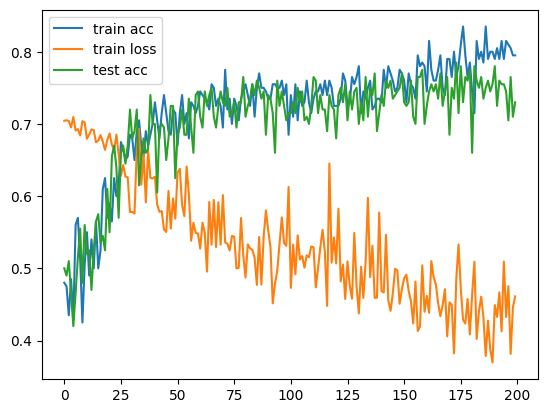

In [17]:
plt.plot(train_accs, label="train acc")
plt.plot(train_loss, label="train loss")
plt.plot(test_accs, label="test acc")
plt.legend()
plt.show()